### 机器翻译
> * 给定一个源语言的句子，自动翻译程目标语言
> * 这两个句子可以有不同的长度

### Seq2Seq
> * 编码器是一个RNN，读取输入句子
>> * 可以是双向
> * 解码器是用另外一个RNN来输出
> ![](../images/Seq2Seq.png)

### 编码器-解码器细节
> * 编码器是没有输出的RNN
> * 编码器最后时间步的隐状态用作解码器的初始隐状态

### 训练和推理的区别
> * 训练时解码器使用目标句子作为输入
> ![](../images/train.png)
> * 推理：
> ![](../images/inference.png)

### 衡量生成序列好坏的BLEU
> * $p_n$是预测中所有n-gram的精度
>> * 标签序列A,B,C,D,E,F和预测序列A,B,C,D，有$p_1=4/5,p_2=3/4,p_3=1/3,p_4=0,p_1$表示一元检测预测句子在源句子中存在的概率，即A存在，B存在，C存在，D存在，有一个B存在位置不匹配，故为$4/5$
> * BLEU定义：$exp\lbrace min\lbrace 0,1-\frac{len(label)}{len(pred)} \rbrace \rbrace \prod_{n=1}^{k}p_n^{1/2^n}$，其中$exp\lbrace min\lbrace 0,1-\frac{len(label)}{len(pred)} \rbrace\rbrace$惩罚过短的预测，$\prod_{n=1}^{k}p_n^{1/2^n}$长匹配有高权重，匹配序列越长，所分配的权重越高

### 总结
> * Seq2Seq从一个句子生成另一个句子
> * 编码器和解码器都是RNN
> * 将编码器最后时间隐状态来初始解码器隐状态来完成信息传递
> * 常用BLEU来衡量生成序列的好坏

In [44]:
import collections
import math
import torch
from torch import nn
from d2l import limutorch as d2l

In [2]:
"""编码器"""
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # 输出X的形状，（batch_size， num_steps, embed_size）
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应时间步
        X = X.permute(1, 0, 2)
        # 如果未提交状态，则默认为0
        output, state = self.rnn(X)
        # output形状为(num_steps, batch_size, num_hiddens)
        # state形状为：(num_layers, batch_size, num_hiddens)
        return output, state

In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [20]:
"""解码器"""
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出X形状为（batch_size， num_steps， embed_size）
        X = self.embedding(X).permute(1, 0, 2)
        # print(X.shape)
        # print(state[-1].shape)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        # print(context.shape)
        # 将编码器的隐状态作为输入放入解码器中进行训练
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output形状：(batch_size, num_steps, vocab_size)
        # state形状：(num_layers, batch_size, num_hiddens)
        return output, state

In [5]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

torch.Size([7, 4, 8])
torch.Size([4, 16])
torch.Size([7, 4, 16])


(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

#### 损失函数

In [45]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    print('maxlen:', maxlen)
    M = torch.arange((maxlen), dtype=torch.float32, device=X.device)
    print(M)
    N = valid_len
    print(N)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    print(mask)
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

maxlen: 3
tensor([0., 1., 2.])
tensor([1, 2])
tensor([[ True, False, False],
        [ True,  True, False]])


tensor([[1, 0, 0],
        [4, 5, 0]])

In [7]:
"""可以使用次函数屏蔽最后几个轴上的所有值"""
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

maxlen: 3
tensor([0., 1., 2.])
tensor([1, 2])
tensor([[ True, False, False],
        [ True,  True, False]])


tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [15]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred形状为：（batch_size, num_steps, vocab_size）
    # label形状为：（batch_size, num_steps）
    # valid_len形状为：（batch_size, ）
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        # 求损失函数时需要对预测的值位置进行更改
        # nn.CrossEntropyLoss内部实现了SoftMax，所以输入是三维，经过SoftMax后会变为二维进行求损失
        unweightes_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        # print(unweightes_loss)
        # 最后对dim=1求平均是为了对每个句子求loss平均
        weighted_loss = (unweightes_loss * weights).mean(dim=1)
        return weighted_loss

In [9]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

maxlen: 4
tensor([0., 1., 2., 3.])
tensor([4, 2, 0])
tensor([[ True,  True,  True,  True],
        [ True,  True, False, False],
        [False, False, False, False]])
tensor([[2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026]])


tensor([2.3026, 1.1513, 0.0000])

#### 训练

In [22]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) # 训练损失总和， 词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch+1, (metric[0] / metric[1]))
    print(f'loss{metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss0.020, 8990.5 tokens/sec on cuda:0


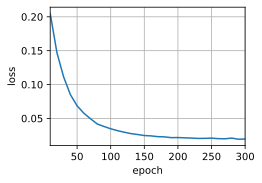

In [30]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

#### 预测

In [37]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab,
                    num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    # 对源词元长度填充到num_steps长度
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # 预热网络，使其初始化最初解码器的隐状态
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 在目标词元中添加初始标签
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    # 输出预测最长为num_steps，超过这个长度就结束，不再预测
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 使用具有预测最高可能性的词元作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就结束了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


#### 预测序列的评估

In [38]:
def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            # 对真实语句进行n语法进行分割，按字典存储
            label_subs[' '.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            # 如果预测语句按n词元分割的语句在label_subs查找出来的值大于0，则说明该语句出现在真实语句中，对匹配度进行加1操作
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                # 匹配过后应当删去该匹配语句，以防后续出现频繁匹配，但是原句中只有一次匹配
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [41]:
engs = ['go .', " i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, belu {bleu(translation, fra, k=2):.3f}')

go . => va !, belu 1.000
 i lost . => j’ai <unk> un un fait fait <unk> ., belu 0.000
he's calm . => il essaye ., belu 0.000
i'm home . => je suis chez suis suis <unk> ?, belu 0.497


In [43]:
" A b".split(' ')

['', 'A', 'b']